In [113]:
import pyspark
import pandas as pd
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import StringType

In [114]:
pd.set_option('display.max_rows', 9999)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 3)

In [115]:
spark = SparkSession.builder.master("local[2]").appName('car_accidents').getOrCreate()

In [116]:
df = spark.read.csv('C:/Users/a842488/OneDrive - Atos/Desktop/Project', inferSchema='True', header=True)
#df = df.sample(0.1)

# Data Analysis

In [117]:
df.dtypes

[('ID', 'string'),
 ('Severity', 'int'),
 ('Start_Time', 'string'),
 ('End_Time', 'string'),
 ('Start_Lat', 'double'),
 ('Start_Lng', 'double'),
 ('End_Lat', 'double'),
 ('End_Lng', 'double'),
 ('Distance(mi)', 'double'),
 ('Description', 'string'),
 ('Number', 'double'),
 ('Street', 'string'),
 ('Side', 'string'),
 ('City', 'string'),
 ('County', 'string'),
 ('State', 'string'),
 ('Zipcode', 'string'),
 ('Country', 'string'),
 ('Timezone', 'string'),
 ('Airport_Code', 'string'),
 ('Weather_Timestamp', 'string'),
 ('Temperature(F)', 'double'),
 ('Wind_Chill(F)', 'double'),
 ('Humidity(%)', 'double'),
 ('Pressure(in)', 'double'),
 ('Visibility(mi)', 'double'),
 ('Wind_Direction', 'string'),
 ('Wind_Speed(mph)', 'double'),
 ('Precipitation(in)', 'double'),
 ('Weather_Condition', 'string'),
 ('Amenity', 'boolean'),
 ('Bump', 'boolean'),
 ('Crossing', 'boolean'),
 ('Give_Way', 'boolean'),
 ('Junction', 'boolean'),
 ('No_Exit', 'boolean'),
 ('Railway', 'boolean'),
 ('Roundabout', 'boolean')

In [118]:
df.limit(5).toPandas().head(5)

,ID,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,Number,Street,Side,City,County,State,Zipcode,Country,Timezone,Airport_Code,Weather_Timestamp,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,3,2016-02-08 00:37:08,2016-02-08 06:37:08,40.109,-83.093,40.112,-83.032,3.230,Between Sawmill Rd/Exit 20 and OH-315/Olentangy Riv Rd/Exit 22 - Accident.,NaN,Outerbelt E,R,Dublin,Franklin,OH,43017,US,US/Eastern,KOSU,2016-02-08 00:53:00,42.1,36.1,58.0,29.76,10.0,SW,10.4,0.00,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,2,2016-02-08 05:56:20,2016-02-08 11:56:20,39.865,-84.063,39.865,-84.049,0.747,At OH-4/OH-235/Exit 41 - Accident.,NaN,I-70 E,R,Dayton,Montgomery,OH,45424,US,US/Eastern,KFFO,2016-02-08 05:58:00,36.9,NaN,91.0,29.68,10.0,Calm,NaN,0.02,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night
2,A-3,2,2016-02-08 06:15:39,2016-02-08 12:15:39,39.103,-84.525,39.102,-84.524,0.055,At I-71/US-50/Exit 1 - Accident.,NaN,I-75 S,R,Cincinnati,Hamilton,OH,45203,US,US/Eastern,KLUK,2016-02-08 05:53:00,36.0,NaN,97.0,29.70,10.0,Calm,NaN,0.02,Overcast,False,False,False,False,True,False,False,False,False,False,False,False,False,Night,Night,Night,Day
3,A-4,2,2016-02-08 06:51:45,2016-02-08 12:51:45,41.062,-81.538,41.062,-81.535,0.123,At Dart Ave/Exit 21 - Accident.,NaN,I-77 N,R,Akron,Summit,OH,44311,US,US/Eastern,KAKR,2016-02-08 06:54:00,39.0,NaN,55.0,29.65,10.0,Calm,NaN,NaN,Overcast,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Day,Day
4,A-5,3,2016-02-08 07:53:43,2016-02-08 13:53:43,39.172,-84.493,39.170,-84.502,0.500,At Mitchell Ave/Exit 6 - Accident.,NaN,I-75 S,R,Cincinnati,Hamilton,OH,45217,US,US/Eastern,KLUK,2016-02-08 07:53:00,37.0,29.8,93.0,29.69,10.0,WSW,10.4,0.01,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day


In [119]:
# add new columns
df = df.withColumn('hour_of_accident', df.Start_Time.substr(12,2)) \
       .withColumn('date_of_accident', df.Start_Time.substr(1,10))

In [120]:
# create pivot table
distinct_states = [x.State for x in df.select('State').distinct().collect()]
df_county= df.groupBy('hour_of_accident').pivot('State',distinct_states).count().orderBy('hour_of_accident')

In [121]:
# create function to highlight the biggest value in each column
def highlight_max(data, color='yellow'):
    '''
    highlight the maximum in a Series or DataFrame
    '''
    attr = 'background-color: {}'.format(color)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_max = data == data.max()
        return [attr if v else '' for v in is_max]
    else:  # from .apply(axis=None)
        is_max = data == data.max().max()
        return pd.DataFrame(np.where(is_max, attr, ''),
                            index=data.index, columns=data.columns)

In [122]:
# wont be visible on git
df_county = df_county.toPandas().set_index('hour_of_accident')
df_county = df_county.fillna(0)
df_county = df_county.applymap('{:,.0f}'.format)
df_county.style.apply(highlight_max)

,SC,AZ,LA,MN,NJ,DC,OR,VA,RI,KY,WY,NH,MI,NV,WI,ID,CA,NE,CT,MT,NC,VT,MD,DE,MO,IL,ME,ND,WA,MS,AL,IN,OH,TN,IA,NM,PA,SD,NY,TX,WV,GA,MA,KS,CO,FL,AR,OK,UT
hour_of_accident,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00,"2,782","1,354","1,267","2,402","1,307",215,"2,847","2,660",57,100,13,105,"1,110",209,131,226,"18,774",69,855,491,"2,628",19,"1,755",109,615,724,49,68,545,143,502,586,375,"1,623",304,54,"3,110",11,"2,873","3,759",237,"1,213",117,190,275,"8,065",347,65,"1,465"
01,"2,455","1,233","1,069","2,306","1,006",134,"2,649","2,221",46,72,31,58,811,120,86,194,"17,738",47,665,438,"1,745",2,"1,502",89,632,792,12,59,547,139,474,427,303,"1,134",239,55,"2,780",7,"2,427","3,211",181,809,82,156,254,"6,621",347,55,910
02,"2,402","1,170",955,"1,988",907,162,"2,458","2,112",43,70,6,54,902,131,100,154,"16,283",30,524,378,"1,750",2,"1,475",83,538,678,12,54,534,84,421,367,315,996,188,46,"2,477",3,"1,989","3,351",163,810,64,124,238,"6,708",286,42,816
03,"1,971","1,039",895,"1,670",820,137,"2,205","1,696",17,67,11,53,721,113,70,103,"14,123",34,434,333,"1,330",0,"1,369",64,445,574,15,41,492,56,336,384,269,795,172,36,"1,991",3,"1,824","2,836",135,823,53,74,254,"6,890",201,37,645
04,"1,583","1,024",953,"1,588",913,158,"2,359","1,784",22,77,27,46,675,126,126,104,"14,977",26,554,338,"1,230",2,"1,286",99,425,822,22,61,556,76,360,401,261,966,241,45,"2,014",7,"2,086","2,851",160,771,57,116,234,"8,181",191,36,788
05,"1,973","1,390","1,340","2,429","1,585",248,"3,481","2,863",53,184,26,85,956,231,251,187,"23,761",56,691,410,"1,948",8,"1,971",91,760,"1,318",30,68,"1,039",118,539,609,441,"1,472",235,58,"2,668",2,"3,512","4,816",207,"1,130",212,159,492,"12,338",273,95,"1,494"
06,"2,844","1,938","1,866","3,837","2,693",379,"4,588","4,376",122,244,50,156,"1,592",348,370,268,"31,032",164,"1,144",711,"2,805",16,"2,710",160,"1,328","2,291",50,68,"1,472",176,592,922,933,"2,089",394,90,"3,494",8,"4,802","7,027",284,"1,996",375,301,"1,285","13,902",367,211,"2,290"
07,"3,508","2,172","1,842","5,099","3,559",495,"5,720","5,188",284,404,39,255,"2,242",408,601,421,"36,067",300,"1,487",850,"4,303",24,"3,281",216,"1,879","2,820",131,123,"1,605",293,952,"1,351","1,572","2,444",476,133,"4,204",2,"5,549","7,899",272,"2,368",461,640,"1,638","15,700",550,376,"2,988"
08,"3,206","2,532","1,734","4,397","2,873",483,"5,882","5,121",392,496,75,320,"2,345",402,717,416,"33,950",309,"1,398",833,"4,712",28,"3,145",183,"1,830","2,823",173,106,"1,613",317,876,"1,235","1,696","2,174",525,149,"3,833",3,"5,312","6,863",309,"2,129",504,660,"1,454","16,358",479,334,"3,175"


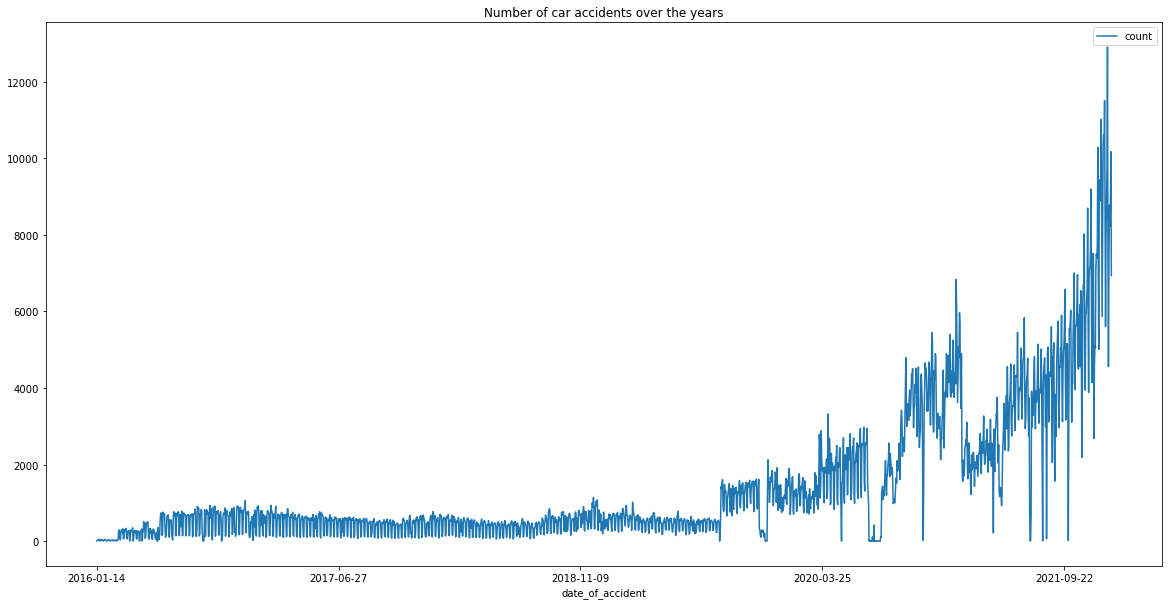

In [123]:
df_date = df.select('date_of_accident').groupBy('date_of_accident').count().orderBy('date_of_accident').toPandas()
df_date_chart = df_date.plot.line(title = 'Number of car accidents over the years', x='date_of_accident', figsize= (20,10))

In [124]:
# top 10 cities with car accidents
df_city = df.select('City').groupBy('City').count().orderBy(F.desc('count'))
df_city.toPandas().head(11)

,City,count
0,Miami,106966
1,Los Angeles,68956
2,Orlando,54691
3,Dallas,41979
4,Houston,39448
5,Charlotte,33152
6,Sacramento,32559
7,San Diego,26627
8,Raleigh,22840
9,Minneapolis,22768


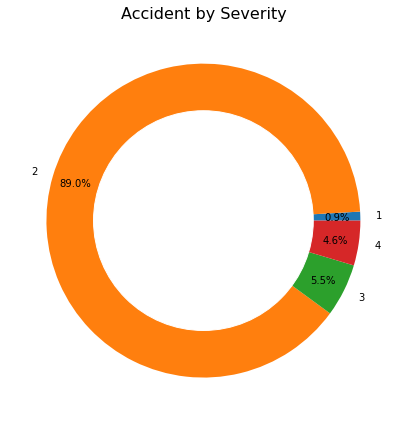

In [125]:
df_severity = df.select('ID','Severity').toPandas().groupby('Severity').count()['ID']

import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(8, 6), subplot_kw=dict(aspect="equal"))
label = [1,2,3,4]
plt.pie(df_severity, labels=label,
        autopct='%1.1f%%', pctdistance=0.85)
circle = plt.Circle( (0,0), 0.7, color='white')
p=plt.gcf()
p.gca().add_artist(circle)
ax.set_title("Accident by Severity",fontdict={'fontsize': 16})
plt.tight_layout()
plt.show()

In [126]:
df.limit(2).toPandas().head()

,ID,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,Number,Street,Side,City,County,State,Zipcode,Country,Timezone,Airport_Code,Weather_Timestamp,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,hour_of_accident,date_of_accident
0,A-1,3,2016-02-08 00:37:08,2016-02-08 06:37:08,40.109,-83.093,40.112,-83.032,3.230,Between Sawmill Rd/Exit 20 and OH-315/Olentangy Riv Rd/Exit 22 - Accident.,NaN,Outerbelt E,R,Dublin,Franklin,OH,43017,US,US/Eastern,KOSU,2016-02-08 00:53:00,42.1,36.1,58.0,29.76,10.0,SW,10.4,0.00,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night,00,2016-02-08
1,A-2,2,2016-02-08 05:56:20,2016-02-08 11:56:20,39.865,-84.063,39.865,-84.049,0.747,At OH-4/OH-235/Exit 41 - Accident.,NaN,I-70 E,R,Dayton,Montgomery,OH,45424,US,US/Eastern,KFFO,2016-02-08 05:58:00,36.9,NaN,91.0,29.68,10.0,Calm,NaN,0.02,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night,05,2016-02-08


In [127]:
numerical_cols = df.columns[21:29]
categorical_cols = df.columns[29:47]

#lets try drop na
df_test = df.na.drop('any')

for i in categorical_cols:
    df_test = df_test.withColumn(i,F.col(i).cast(StringType()))
    
df_test = df_test.drop('Wind_Direction')
numerical_cols.remove('Wind_Direction')

In [128]:
# use OneHotEncoder to convert categorical columns into vectors
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, VectorIndexer
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

list_of_cols = categorical_cols

stringIndexer = [StringIndexer(inputCol=i, outputCol=i + "_index").fit(df_test) for i in list_of_cols]

encoders = [OneHotEncoder(dropLast=False, inputCol=indexer.getOutputCol(), outputCol="job_vec_"+indexer.getOutputCol()) for indexer in stringIndexer]

list_of_encoders = [encoder.getOutputCol() for encoder in encoders]
list_of_encoders = numerical_cols + list_of_encoders 

vector_assembler = VectorAssembler(inputCols=list_of_encoders, outputCol="features")

pipeline = Pipeline(stages = stringIndexer + encoders + [vector_assembler])
model = pipeline.fit(df_test)
df = model.transform(df_test)

In [129]:
from pyspark.ml.regression import GBTRegressor

va_df = df.select(['features','Severity'])
(train, test) = va_df.randomSplit([0.8, 0.2], seed=123)

gbtr = GBTRegressor(featuresCol='features', labelCol='Severity', maxIter=100)
gbtr = gbtr.fit(train)

In [130]:
mdata = gbtr.transform(test)
mdata.show(3)
 
rmse=RegressionEvaluator(labelCol="Severity", predictionCol="prediction", metricName="rmse")
rmse=rmse.evaluate(mdata) 
 
mae=RegressionEvaluator(labelCol="Severity", predictionCol="prediction", metricName="mae")
mae=mae.evaluate(mdata) 
 
r2=RegressionEvaluator(labelCol="Severity", predictionCol="prediction", metricName="r2")
r2=r2.evaluate(mdata)

print("RMSE: ", rmse)
print("MAE: ", mae)
print("R-squared: ", r2)

+--------------------+--------+------------------+
|            features|Severity|        prediction|
+--------------------+--------+------------------+
|(131,[0,1,2,3,4,5...|       2| 2.131516578651607|
|(131,[0,1,2,3,4,5...|       2|2.0751430113148626|
|(131,[0,1,2,3,4,5...|       2|2.0270329307189012|
+--------------------+--------+------------------+
only showing top 3 rows

RMSE:  0.3753467747037141
MAE:  0.1453543546508578
R-squared:  0.0338114679993895


In [131]:
mdata = mdata.withColumn('prediction',F.round(F.col('prediction'),0)) \
             .withColumn('check', F.when(F.col('Severity') == F.col('prediction'), 1).otherwise(0))

In [132]:
a = mdata.select('check').groupBy('check').count()
a.show()

+-----+------+
|check| count|
+-----+------+
|    1|177062|
|    0| 10644|
+-----+------+



In [ ]:
187706

In [13]:
df_model_test1 = df.select('date_of_accident','Temperature(F)').groupBy('date_of_accident') \
                   .count() \
                   .orderBy('date_of_accident')

df_model_test2 = df.select('date_of_accident','Temperature(F)','Wind_Chill(F)','Humidity(%)','Pressure(in)','Visibility(mi)','Wind_Speed(mph)','Precipitation(in)').groupBy('date_of_accident') \
                   .avg('Temperature(F)','Wind_Chill(F)','Humidity(%)','Pressure(in)','Visibility(mi)','Wind_Speed(mph)','Precipitation(in)') \
                   .orderBy('date_of_accident') 

df_model = df_model_test1.join(df_model_test2, ['date_of_accident'])
df_model = df_model.fillna(0)

In [14]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler, StringIndexer

assembler = VectorAssembler(
    inputCols=df_model.columns[2::],
    outputCol='features')

df_model = assembler.transform(df_model)
df_model = df_model.select('date_of_accident', 'count', 'features')

In [15]:
df_model.limit(2).toPandas().head()

,date_of_accident,count,features
0,2016-08-17,60,"[80.35500000000002, 0.0, 65.9, 30.04533333333332, 8.979999999999999, 8.08125, 0.22399999999999998]"
1,2017-05-14,15,"[66.24, 0.0, 54.357142857142854, 29.841333333333335, 9.466666666666667, 10.899999999999999, 0.0]"
